# Example full chip design

In [1]:
%load_ext autoreload
%autoreload 2

# Import Modules

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs

In [3]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.lumped.cap_n_interdigital import CapNInterdigital
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled

from qiskit_metal.qlibrary.tlines.framed_path import RouteFramed
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

from collections import OrderedDict

from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

## Define "TransmonPocket_sqnl"

In [4]:
from qiskit_metal.qlibrary.core import BaseQubit
import numpy as np
class TransmonPocket_sqnl(BaseQubit):
    default_options = Dict(
        pad_gap='30um',
        inductor_width='20um',
        pad_width='455um',
        pad_height='90um',
        pocket_width='650um',
        pocket_height='650um',
        # 90 has dipole aligned along the +X axis,
        # while 0 has dipole aligned along the +Y axis
        _default_connection_pads=Dict(
            connector_type='0',  # 0 = Claw type, 1 = T-shape
            pad_width='125um',
            pad_height='30um',
            pad_cpw_shift='0um',
            pad_cpw_extent='25um',
            claw_length='30um',
            claw_width='10um',
            claw_gap='6um',
            claw_cpw_length='40um',
            claw_cpw_width='10um',
            ground_spacing='5um',
            connector_location= '0'  # 0~5 means six locations with rotated CCW starting from right-top site
        ))
    """Default drawing options"""

    component_metadata = Dict(short_name='Pocket_claw',
                              _qgeometry_table_path='True',
                              _qgeometry_table_poly='True',
                              _qgeometry_table_junction='True')
    """Component metadata"""

    TOOLTIP = """The base `TransmonPocket_sqnl` class."""

    def make(self):
        """Define the way the options are turned into QGeometry.

        The make function implements the logic that creates the geoemtry
        (poly, path, etc.) from the qcomponent.options dictionary of
        parameters, and the adds them to the design, using
        qcomponent.add_qgeometry(...), adding in extra needed
        information, such as layer, subtract, etc.
        """
        self.make_pocket()
        self.make_connection_pads()

    def make_pocket(self):
        """Makes standard transmon in a pocket."""

        # self.p allows us to directly access parsed values (string -> numbers) form the user option
        p = self.p

        # extract chip name
        chip = p.chip

        # since we will reuse these options, parse them once and define them as varaibles
        pad_width = p.pad_width
        pad_height = p.pad_height
        pad_gap = p.pad_gap

        # make the pads as rectangles (shapely polygons)
        pad = draw.rectangle(pad_width, pad_height)
        pad_top = draw.translate(pad, 0, +(pad_height + pad_gap) / 2.)
        pad_bot = draw.translate(pad, 0, -(pad_height + pad_gap) / 2.)

        rect_jj = draw.LineString([(0, -pad_gap / 2), (0, +pad_gap / 2)])
        # the draw.rectangle representing the josephson junction
        # rect_jj = draw.rectangle(p.inductor_width, pad_gap)

        rect_pk = draw.rectangle(p.pocket_width, p.pocket_height)

        # Rotate and translate all qgeometry as needed.
        # Done with utility functions in Metal 'draw_utility' for easy rotation/translation
        # NOTE: Should modify so rotate/translate accepts qgeometry, would allow for
        # smoother implementation.
        polys = [rect_jj, pad_top, pad_bot, rect_pk]
        polys = draw.rotate(polys, p.orientation, origin=(0, 0))
        polys = draw.translate(polys, p.pos_x, p.pos_y)
        [rect_jj, pad_top, pad_bot, rect_pk] = polys

        # Use the geometry to create Metal qgeometry
        self.add_qgeometry('poly',
                           dict(pad_top=pad_top, pad_bot=pad_bot),
                           chip=chip)
        self.add_qgeometry('poly',
                           dict(rect_pk=rect_pk),
                           subtract=True,
                           chip=chip)
        # self.add_qgeometry('poly', dict(
        #     rect_jj=rect_jj), helper=True)
        self.add_qgeometry('junction',
                           dict(rect_jj=rect_jj),
                           width=p.inductor_width,
                           chip=chip)

    def make_connection_pads(self):
        """Makes standard transmon in a pocket."""
        for name in self.options.connection_pads:
            self.make_connection_pad(name)

    def make_connection_pad(self, name: str):
        """Makes n individual connector.

        Args:
            name (str) : Name of the connector
        """
        # self.p allows us to directly access parsed values (string -> numbers) form the user option
        p = self.p
        pc = self.p.connection_pads[name]  # parser on connector options
        # extract chip name
        chip = p.chip
    
        if pc.connector_type == 0:  # Claw connector
            
            # define commonly used variables once
            pad_width = p.pad_width
            pad_height = p.pad_height
            pad_gap = p.pad_gap
            pocket_width = p.pocket_width
            pocket_height = p.pocket_height
    
            c_g = pc.claw_gap
            c_l = pc.claw_length
            c_w = pc.claw_width
            c_c_w = pc.claw_cpw_width
            c_c_l = pc.claw_cpw_length
            g_s = pc.ground_spacing
            con_loc = pc.connector_location
    
            claw_cpw = draw.box(-c_w, -c_c_w / 2, -c_c_l - c_w, c_c_w / 2)
            if con_loc == 0 or  con_loc == 2 or  con_loc == 3 or  con_loc == 5:
                t_claw_height = 2*c_g + 2 * c_w + pad_height  # temp value
    
                claw_base     = draw.box(-c_w, -(t_claw_height) / 2, c_l, t_claw_height / 2)
                claw_subtract = draw.box(0, -t_claw_height / 2 + c_w, c_l, t_claw_height / 2 - c_w)
                claw_base = claw_base.difference(claw_subtract)
    
                connector_arm = draw.shapely.ops.unary_union([claw_base, claw_cpw])
                connector_etcher = draw.buffer(connector_arm, c_g)
            elif con_loc == 1 or  con_loc == 4:
                t_claw_height = 2*c_g + 2 * c_w + pad_width  # temp value
    
                claw_base     = draw.box(-c_w, -(t_claw_height) / 2, c_l, t_claw_height / 2)
                claw_subtract = draw.box(0, -t_claw_height / 2 + c_w, c_l, t_claw_height / 2 - c_w)
                claw_base = claw_base.difference(claw_subtract)
    
                connector_arm = draw.shapely.ops.unary_union([claw_base, claw_cpw])
                connector_etcher = draw.buffer(connector_arm, g_s)
            else:
                print('Not appropriate position of connector')
            
            port_line = draw.LineString([(- c_w, 0),
                                     (-c_c_l - c_w, 0)])

            claw_rotate = 0
            if con_loc == 0:
                claw_rotate = -180
            elif con_loc == 1:
                claw_rotate = -90
            elif con_loc == 2:
                claw_rotate = 0
            elif con_loc == 3:
                claw_rotate = 0
            elif con_loc == 4:
                claw_rotate = 90
            elif con_loc == 5:
                claw_rotate = 180
    
            claw_translate_x = (con_loc==0 or con_loc==5)*(pad_width/2 + g_s) + (con_loc==2 or con_loc==3)*(-pad_width/2 - g_s)
            claw_translate_y = (con_loc==0 or con_loc==2)*(pad_height + pad_gap)/2 + (con_loc==5 or con_loc==3)*(-pad_height - pad_gap)/2 + (con_loc==1)*(pad_height + pad_gap/2 + g_s) - (con_loc==4)*(pad_height + pad_gap/2 + g_s)
            
            # Rotates and translates the connector polygons (and temporary port_line)
            polys = [connector_arm, connector_etcher, port_line]
            polys = draw.rotate(polys, claw_rotate, origin=(0, 0))
            polys = draw.translate(polys, claw_translate_x, claw_translate_y)
            #polys = draw.rotate(polys, p.orientation, origin=(0, 0))
            polys = draw.translate(polys, p.pos_x, p.pos_y)
            [connector_arm, connector_etcher, port_line] = polys
    
            # Generates qgeometry for the connector pads
            self.add_qgeometry('poly', {f'{name}_connector_arm': connector_arm},
                               chip=chip)
            self.add_qgeometry('poly',
                               {f'{name}_connector_etcher': connector_etcher},
                               subtract=True,
                               chip=chip)
    
            self.add_pin(name, points=port_line.coords, width=c_c_w,input_as_norm=True)
        elif pc.connector_type == 1:  # T-shape connector
            
            # define commonly used variables once
            pad_width = p.pad_width
            pad_height = p.pad_height
            pad_gap = p.pad_gap
            pocket_width = p.pocket_width
            pocket_height = p.pocket_height
    
            c_g = pc.claw_gap
            c_l = 0
            c_w = pc.claw_width
            c_c_w = pc.claw_cpw_width
            c_c_l = pc.claw_cpw_length
            g_s = pc.ground_spacing
            con_loc = pc.connector_location
    
            claw_cpw = draw.box(-c_w, -c_c_w / 2, -c_c_l - c_w, c_c_w / 2)
            if con_loc == 0 or  con_loc == 2 or  con_loc == 3 or  con_loc == 5:
                t_claw_height = pc.t_claw_height
    
                claw_base     = draw.box(-c_w, -(t_claw_height) / 2, c_l, t_claw_height / 2)
                claw_subtract = draw.box(0, -t_claw_height / 2 + c_w, c_l, t_claw_height / 2 - c_w)
                claw_base = claw_base.difference(claw_subtract)
    
                connector_arm = draw.shapely.ops.unary_union([claw_base, claw_cpw])
                connector_etcher = draw.buffer(connector_arm, c_g)
            elif con_loc == 1 or  con_loc == 4:
                t_claw_height = pc.t_claw_height
    
                claw_base     = draw.box(-c_w, -(t_claw_height) / 2, c_l, t_claw_height / 2)
                claw_subtract = draw.box(0, -t_claw_height / 2 + c_w, c_l, t_claw_height / 2 - c_w)
                claw_base = claw_base.difference(claw_subtract)
    
                connector_arm = draw.shapely.ops.unary_union([claw_base, claw_cpw])
                connector_etcher = draw.buffer(connector_arm, c_g)
            else:
                print('Not appropriate position of connector')
            
            port_line = draw.LineString([(- c_w, 0),
                                     (-c_c_l - c_w, 0)])

            claw_rotate = 0
            if con_loc == 0:
                claw_rotate = -180
            elif con_loc == 1:
                claw_rotate = -90
            elif con_loc == 2:
                claw_rotate = 0
            elif con_loc == 3:
                claw_rotate = 0
            elif con_loc == 4:
                claw_rotate = 90
            elif con_loc == 5:
                claw_rotate = 180
    
            claw_translate_x = (con_loc==0 or con_loc==5)*(pad_width/2 + g_s) + (con_loc==2 or con_loc==3)*(-pad_width/2 - g_s)
            claw_translate_y = (con_loc==0 or con_loc==2)*(pad_height + pad_gap)/2 + (con_loc==5 or con_loc==3)*(-pad_height - pad_gap)/2 + (con_loc==1)*(pad_height + pad_gap/2 + g_s) - (con_loc==4)*(pad_height + pad_gap/2 + g_s)
            
            # Rotates and translates the connector polygons (and temporary port_line)
            polys = [connector_arm, connector_etcher, port_line]
            polys = draw.rotate(polys, claw_rotate, origin=(0, 0))
            polys = draw.translate(polys, claw_translate_x, claw_translate_y)
            polys = draw.rotate(polys, p.orientation, origin=(0, 0))
            polys = draw.translate(polys, p.pos_x, p.pos_y)
            [connector_arm, connector_etcher, port_line] = polys
    
            # Generates qgeometry for the connector pads
            self.add_qgeometry('poly', {f'{name}_connector_arm': connector_arm},
                               chip=chip)
            self.add_qgeometry('poly',
                               {f'{name}_connector_etcher': connector_etcher},
                               subtract=True,
                               chip=chip)
    
            self.add_pin(name, points=port_line.coords, width=c_c_w,input_as_norm=True)

        else:
            print('Incorrect connector type')
            
        

## Define "LineTee_sqnl"

In [5]:
from qiskit_metal.qlibrary.core import QComponent
class LineTee_sqnl(QComponent):
    """Generates a three pin (+) structure comprised of a primary two pin CPW
    transmission line, and a secondary one pin neighboring CPW transmission
    line that is capacitively coupled to the primary. Such a structure can be
    used, as an example, for generating CPW resonator hangars off of a
    transmission line. (0,0) represents the center position of the component.

    Inherits QComponent class.

    ::

                  (0,0)
        +--------------------------+
                    |
                    |
                    |
                    |
                    |
                    +

    .. image::
        LineTee.png

    .. meta::
        Line Tee

    Options:
        * prime_width: '10um' -- The width of the trace of the two pin CPW transmission line
        * prime_gap: '6um' -- The dielectric gap of the two pin CPW transmission line
        * second_width: '10um' -- The width of the trace of the one pin CPW transmission line
        * second_gap: '6um' -- The dielectric gap of the one pin CPW transmission line (also for the capacitor)
        * t_length: '50um' -- The length for the t branches
        * C_box_width: '50um'
        * C_box_height: '20um'
        * C_box_gap: '20um'
        * C_gap: '5um'
    """
    component_metadata = Dict(short_name='cpw', _qgeometry_table_path='True')
    """Component metadata"""

    #Currently setting the primary CPW length based on the coupling_length
    #May want it to be it's own value that the user can control?
    default_options = Dict(prime_width='10um',
                           prime_gap='6um',
                           second_width='10um',
                           second_gap='6um',
                           t_length='50um')
    """Default connector options"""

    TOOLTIP = """Generates a three pin (+) structure comprised of a primary two pin CPW
    transmission line, and a secondary one pin neighboring CPW transmission
    line that is capacitively coupled to the primary."""

    def make(self):
        """Build the component."""
        p = self.p
        prime_cpw_length = p.t_length * 2
        C_box_width = p.C_box_width
        C_box_height = p.C_box_height
        C_box_gap = p.C_box_gap
        C_gap = p.C_gap
        
        #Primary CPW
        prime_cpw = draw.LineString([[-prime_cpw_length / 2, 0],
                                     [prime_cpw_length / 2, 0]])

        #Secondary CPW
        second_cpw = draw.LineString([[0, -p.prime_width / 2], [0,
                                                                -p.t_length]])
        
        #Capacitor
        C_box = draw.box(-C_box_width/2,-p.t_length-C_box_height,C_box_width/2,-p.t_length)
        C_gap = draw.box(-C_box_width/2-C_box_gap,-p.t_length-C_box_height-C_gap,C_box_width/2+C_box_gap,-p.t_length+C_box_gap)
        
        #Rotate and Translate
        c_items = [prime_cpw, second_cpw]
        c_items = draw.rotate(c_items, p.orientation, origin=(0, 0))
        c_items = draw.translate(c_items, p.pos_x, p.pos_y)
        [prime_cpw, second_cpw] = c_items
        
        C_boxes = [C_box,C_gap]
        C_boxes = draw.rotate(C_boxes, p.orientation, origin=(0, 0))
        C_boxes = draw.translate(C_boxes, p.pos_x, p.pos_y)
        [C_box,C_gap] = C_boxes
        
        #Add to qgeometry tables
        self.add_qgeometry('path', {'prime_cpw': prime_cpw},
                           width=p.prime_width,
                           layer=p.layer)
        self.add_qgeometry('path', {'prime_cpw_sub': prime_cpw},
                           width=p.prime_width + 2 * p.prime_gap,
                           subtract=True,
                           layer=p.layer)
        self.add_qgeometry('path', {'second_cpw': second_cpw},
                           width=p.second_width,
                           layer=p.layer)
        self.add_qgeometry('path', {'second_cpw_sub': second_cpw},
                           width=p.second_width + 2 * p.second_gap,
                           subtract=True,
                           layer=p.layer)
        
        self.add_qgeometry('poly', {'C_box': C_box},
                           layer=p.layer)
        self.add_qgeometry('poly', {'C_gap': C_gap},
                           subtract=True,
                           layer=p.layer)

        #Add pins
        prime_pin_list = prime_cpw.coords
        second_pin_list = second_cpw.coords

        self.add_pin('prime_start',
                     points=np.array(prime_pin_list[::-1]),
                     width=p.prime_width,
                     input_as_norm=True)
        self.add_pin('prime_end',
                     points=np.array(prime_pin_list),
                     width=p.prime_width,
                     input_as_norm=True)
        self.add_pin('second_end',
                     points=np.array(second_pin_list),
                     width=p.second_width,
                     input_as_norm=True)


## Chip dimensions

In [6]:
design = metal.designs.DesignPlanar()

gui = metal.MetalGUI(design)

In [7]:
design.overwrite_enabled = True
design.chips.main

{'material': 'silicon',
 'layer_start': '0',
 'layer_end': '2048',
 'size': {'center_x': '0.0mm',
  'center_y': '0.0mm',
  'center_z': '0.0mm',
  'size_x': '9mm',
  'size_y': '6mm',
  'size_z': '-750um',
  'sample_holder_top': '890um',
  'sample_holder_bottom': '1650um'}}

In [8]:
design.chips

{'main': {'material': 'silicon',
  'layer_start': '0',
  'layer_end': '2048',
  'size': {'center_x': '0.0mm',
   'center_y': '0.0mm',
   'center_z': '0.0mm',
   'size_x': '9mm',
   'size_y': '6mm',
   'size_z': '-750um',
   'sample_holder_top': '890um',
   'sample_holder_bottom': '1650um'}}}

In [9]:
design.chips.main.size.size_x = '10mm'
design.chips.main.size.size_y = '10mm'

# Qubits

In [10]:
TransmonPocket_sqnl.get_template_options(design)

{'pos_x': '0.0um',
 'pos_y': '0.0um',
 'orientation': '0.0',
 'chip': 'main',
 'layer': '1',
 'connection_pads': {},
 '_default_connection_pads': {'connector_type': '0',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '0um',
  'pad_cpw_extent': '25um',
  'claw_length': '30um',
  'claw_width': '10um',
  'claw_gap': '6um',
  'claw_cpw_length': '40um',
  'claw_cpw_width': '10um',
  'ground_spacing': '5um',
  'connector_location': '0'},
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'aedt_q3d_wire_bonds': False,
 'aedt_hfss_wire_bonds': False,
 'hfss_inductance': '10nH',
 'hfss_capacitance': 0,
 'hfss_resistance': 0,
 'hfss_mesh_kw_jj': 7e-06,
 'q3d_inductance': '10nH',
 'q3d_capacitance': 0,
 'q3d_resistance': 0,
 'q3d_mesh_kw_jj': 7e-06,
 'gds_cell_name': 'my_other_junction',
 'aedt_q3d_inductance': 1e-08,
 'aedt_q3d_c

In [38]:
options_1 =  dict(
    pad_width = '540 um', 
    pad_height = '132.5 um',
    pad_gap = '65 um', 
    pocket_width = '740 um',
    pocket_height = '530 um',
    connection_pads=dict(
        readout1 = dict(connector_type='0',  # 0 = Claw type, 1 = T-shape type
                       t_claw_height = '400um',
                       ground_spacing='10um',
                       claw_width='20um',
                       claw_gap='10um',
                       claw_cpw_length='100um',
                       claw_cpw_width='20um',
                       connector_location=
                       '0'  # 0 => 'west' arm, 90 => 'north' arm, 180 => 'east' arm
                       ) ,
        control = dict(connector_type='1',  # 0 = Claw type, 1 = T-shape type
                       t_claw_height = '30um',
                       ground_spacing='100um',
                       claw_width='30um',
                       claw_gap='18um',
                       claw_cpw_length='100um',
                       claw_cpw_width='30um',
                       connector_location=
                       '1'  # 0 => 'west' arm, 90 => 'north' arm, 180 => 'east' arm
                       ) 
    ))

In [39]:
q_1 = TransmonPocket_sqnl(design,'Q_1', options = dict(
        pos_x='0mm', 
        pos_y='2.5mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        **options_1))
gui.rebuild()
gui.autoscale()

03:23PM 23s WARNING [check_lengths]: For path table, component=R_11, key=trace has short segments that could cause issues with fillet. Values in (11-11)  are index(es) in shapely geometry.
03:23PM 23s WARNING [check_lengths]: For path table, component=R_11, key=cut has short segments that could cause issues with fillet. Values in (11-11)  are index(es) in shapely geometry.


# Resoantors

## Launch Pads

In [13]:
launch_TL_read_11 = LaunchpadWirebond(design, 
                                   'launch_TL_read_11', 
                                   options = dict(
                                       pos_x = '2.5mm', 
                                       pos_y ='4.3mm', 
                                       orientation = '270',
                                       trace_gap = '10um',
                                       trace_width = '20um',
                                       taper_height = '375um',
                                       pad_width='250um',
                                       pad_height='300um',
                                       pad_gap = '100um'
                                   ))
launch_TL_read_12 = LaunchpadWirebond(design, 
                                   'launch_TL_read_12', 
                                   options = dict(
                                       pos_x = '0mm', 
                                       pos_y ='4.3mm', 
                                       orientation = '270',
                                       trace_gap = '18um',
                                       trace_width = '30um',
                                       taper_height = '375um',
                                       pad_width='250um',
                                       pad_height='300um',
                                       pad_gap = '100um'
                                   ))

gui.rebuild()
gui.autoscale()

In [14]:
CapNInterdigital.get_template_options(design)

{'pos_x': '0.0um',
 'pos_y': '0.0um',
 'orientation': '0.0',
 'chip': 'main',
 'layer': '1',
 'north_width': '10um',
 'north_gap': '6um',
 'south_width': '10um',
 'south_gap': '6um',
 'cap_width': '10um',
 'cap_gap': '6um',
 'cap_gap_ground': '6um',
 'finger_length': '20um',
 'finger_count': '5',
 'cap_distance': '50um',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'aedt_q3d_wire_bonds': False,
 'aedt_hfss_wire_bonds': False}

## IDCs

### Definition

In [15]:
from qiskit_metal.qlibrary.core import QComponent
class CapNInterdigital_sqnl(QComponent):
    
    component_metadata = Dict(short_name='cpw',
                              _qgeometry_table_poly='True',
                              _qgeometry_table_path='True')
    """Component metadata"""

    #Currently setting the primary CPW length based on the coupling_length
    #May want it to be it's own value that the user can control?
    default_options = Dict(north_width='10um',
                           north_gap='6um',
                           south_width='10um',
                           south_gap='6um',
                           cap_width='10um',
                           cap_gap='6um',
                           cap_gap_ground='6um',
                           finger_length='20um',
                           finger_count='5',
                           cap_distance='50um',
                           taper_length='200um'
                          )
    """Default connector options"""

    TOOLTIP = """Generates a two pin (+) structure
     comprised of a north CPW transmission line, 
     and a south transmission line, coupled 
     together via a finger capacitor."""

    def make(self):
        """Build the component."""
        p = self.p
        N = int(p.finger_count)

        #Finger Capacitor
        cap_box = draw.Polygon([[(N * p.cap_width + (N - 1) * p.cap_gap)/2, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2],
                                [p.north_width/2, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2 + p.taper_length],
                                [-p.north_width/2, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2 + p.taper_length],
                                [-(N * p.cap_width + (N - 1) * p.cap_gap)/2, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2],
                                [-(N * p.cap_width + (N - 1) * p.cap_gap)/2, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2],
                                [-p.south_width/2, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2 - p.taper_length],
                                [p.south_width/2, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2 - p.taper_length],
                                [(N * p.cap_width + (N - 1) * p.cap_gap)/2, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2]
                               ])
        make_cut_list = []
        make_cut_list.append([0, (p.finger_length) / 2])
        make_cut_list.append([(p.cap_width) + (p.cap_gap / 2),
                              (p.finger_length) / 2])
        flip = -1

        for i in range(1, N):
            make_cut_list.append([
                i * (p.cap_width) + (2 * i - 1) * (p.cap_gap / 2),
                flip * (p.finger_length) / 2
            ])
            make_cut_list.append([
                (i + 1) * (p.cap_width) + (2 * i + 1) * (p.cap_gap / 2),
                flip * (p.finger_length) / 2
            ])
            flip = flip * -1

        cap_cut = draw.LineString(make_cut_list).buffer(p.cap_gap / 2,
                                                        cap_style=2,
                                                        join_style=2)
        cap_cut = draw.translate(cap_cut,
                                 -(N * p.cap_width + (N - 1) * p.cap_gap) / 2,
                                 0)

        cap_body = draw.subtract(cap_box, cap_cut)
        cap_body = draw.translate(
            cap_body, 0, -p.cap_distance -
            (p.cap_gap + 2 * p.cap_width + p.finger_length) / 2)

        cap_etch = draw.Polygon([[(N * p.cap_width + (N - 1) * p.cap_gap)/2+p.cap_gap_ground, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2],
                                [p.north_width/2+p.north_gap, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2 + p.taper_length],
                                [-p.north_width/2-p.north_gap, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2 + p.taper_length],
                                [-(N * p.cap_width + (N - 1) * p.cap_gap)/2-p.cap_gap_ground, (p.cap_gap + 2 * p.cap_width + p.finger_length)/2],
                                [-(N * p.cap_width + (N - 1) * p.cap_gap)/2-p.cap_gap_ground, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2],
                                [-p.south_width/2-p.south_gap, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2 - p.taper_length],
                                [p.south_width/2+p.south_gap, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2 - p.taper_length],
                                [(N * p.cap_width + (N - 1) * p.cap_gap)/2+p.cap_gap_ground, -(p.cap_gap + 2 * p.cap_width + p.finger_length)/2]
                               ])

        cap_etch = draw.translate(
            cap_etch, 0, -p.cap_distance -
            (p.cap_gap + 2 * p.cap_width + p.finger_length) / 2)

        #CPW
        north_cpw = draw.LineString([[0, p.taper_length], [0, p.taper_length-p.cap_distance]])

        south_cpw = draw.LineString(
            [[
                0, -p.taper_length-p.cap_distance -
                (p.cap_gap + 2 * p.cap_width + p.finger_length)
            ],
             [
                 0, -p.taper_length-2 * p.cap_distance -
                 (p.cap_gap + 2 * p.cap_width + p.finger_length)
             ]])

        #Rotate and Translate
        c_items = [north_cpw, south_cpw, cap_body, cap_etch]
        c_items = draw.rotate(c_items, p.orientation, origin=(0, 0))
        c_items = draw.translate(c_items, p.pos_x, p.pos_y)
        [north_cpw, south_cpw, cap_body, cap_etch] = c_items

        #Add to qgeometry tables
        self.add_qgeometry('path', {'north_cpw': north_cpw},
                           width=p.north_width,
                           layer=p.layer)
        self.add_qgeometry('path', {'north_cpw_sub': north_cpw},
                           width=p.north_width + 2 * p.north_gap,
                           layer=p.layer,
                           subtract=True)

        self.add_qgeometry('path', {'south_cpw': south_cpw},
                           width=p.south_width,
                           layer=p.layer)
        self.add_qgeometry('path', {'south_cpw_sub': south_cpw},
                           width=p.south_width + 2 * p.south_gap,
                           layer=p.layer,
                           subtract=True)

        self.add_qgeometry('poly', {'cap_body': cap_body}, layer=p.layer)
        self.add_qgeometry('poly', {'cap_etch': cap_etch},
                           layer=p.layer,
                           subtract=True)

        #Add pins
        north_pin_list = north_cpw.coords
        south_pin_list = south_cpw.coords

        self.add_pin('north_end',
                     points=np.array(north_pin_list[::-1]),
                     width=p.north_width,
                     input_as_norm=True)
        self.add_pin('south_end',
                     points=np.array(south_pin_list),
                     width=p.south_width,
                     input_as_norm=True)

### Draw

In [16]:
highC_PF_TL_11 = CapNInterdigital_sqnl(design, 
                               'highC_PF_TL_11', 
                               options = dict(
                                   pos_x = '2.5mm',
                                   pos_y = '3.9mm',
                                   orientation = '0',
                                   north_width = '20um', 
                                   north_gap   = '10um', 
                                   south_width = '20um', 
                                   south_gap   = '10um', 
                                   cap_width   = '5um', 
                                   cap_gap   = '1um', 
                                   cap_gap_ground   = '44um', 
                                   finger_length   = '200um', 
                                   finger_count   = '30', 
                                   cap_distance   = '50um',
                                   taper_length   = '200um'
                               ))

gui.rebuild()
gui.autoscale()

In [17]:
option_TL_11 = Dict(hfss_wire_bonds = True,
              pin_inputs=Dict(
                 start_pin=Dict(
                     component='highC_PF_TL_11',
                     pin='north_end'),
                 end_pin=Dict(
                     component='launch_TL_read_11',
                     pin='tie')),
              trace_width='20um',
              trace_gap='10um',qgeometry_types='poly'
             )


TL_11 = RouteStraight(design, 'TL_11', options=option_TL_11)


gui.rebuild()
gui.autoscale()

## Purcell filters

### PF_11

In [61]:
pin_opt_PF_11 = Dict(pin_inputs=Dict(start_pin=Dict(
                                    component='highC_PF_TL_11',
                                    pin='south_end'),
                                    end_pin=Dict(
                                    component='PF_11_open',
                                    pin='open')),
               fillet='89um',
               trace_width='20um',
               trace_gap='10um',
               hfss_wire_bonds = True,
               wb_threshold = '10um',
               wb_offset ='10um'
              )


otg_PF_11 = OpenToGround(design, 'PF_11_open', 
                       options=dict(
                           pos_x='1.320mm', 
                           pos_y='3.299mm',
                           width='20um',
                           gap='10um',
                           orientation=180))

pin_opt_PF_11.pin_inputs.start_pin.component = 'highC_PF_TL_11'
pin_opt_PF_11.pin_inputs.end_pin.component = 'PF_11_open'

# the first step is always stright, let's define by how much (minimum is half the route width):
pin_opt_PF_11.lead.start_straight = '400um + 90um'
pin_opt_PF_11.lead.end_straight = '0um'

# any subsequent step of the lead_start
jogsS_11 = OrderedDict()
jogsS_11[0] = ["R", '200um + 180um']
jogsS_11[1] = ["R", '1000um + 180um']
jogsS_11[2] = ["L", '0um + 180um']
jogsS_11[3] = ["L", '1600um + 180um']
jogsS_11[4] = ["R", '0um + 180um']
jogsS_11[5] = ["R", '1600um + 180um']
jogsS_11[6] = ["L", '0um + 180um']
jogsS_11[7] = ["L", '600um + 180um']

pin_opt_PF_11.lead.start_jogged_extension = jogsS_11
PF_11 = RouteFramed(design, 'PF_11', pin_opt_PF_11)

gui.rebuild()
gui.autoscale()

In [70]:
# PF-R coupler 11
coupler_length_11 = 1e-3

T_coupler_PF_11 = LineTee_sqnl(design, 'T_coupler_PF_11', options=dict(pos_x='1.335mm', 
                                                                       pos_y='3.299mm',
                                             t_length=coupler_length_11,
                                             prime_width = '10um',
                                             prime_gap = '10um',
                                             second_width = '20um',
                                             second_gap = '20um',
                                             C_box_width = '100um',
                                             C_box_gap = '10um',
                                             C_box_height = '20um',
                                             C_gap = '30um',
                                             orientation = -90
                                             ))

gui.rebuild()
gui.autoscale()

## Readout resonators

### R_11

In [52]:
pin_opt_R_11 = Dict(pin_inputs=Dict(start_pin=Dict(
                                    component='Q_1',
                                    pin='readout1'),
                                end_pin=Dict(
                                    component='R_11_open',
                                    pin='open')),
               fillet='89um',
               trace_width='20um',
               trace_gap='10um',
               hfss_wire_bonds = True,
               wb_threshold = '10um',
               wb_offset ='10um'
              )

otg_R_11 = OpenToGround(design, 'R_11_open', 
                       options=dict(
                           pos_x='1.298mm', 
                           pos_y='3.299mm',
                           width='20um',
                           gap='10um',
                           orientation=0))

pin_opt_R_11.pin_inputs.start_pin.component = 'Q_1'
pin_opt_R_11.pin_inputs.end_pin.component = 'R_11_open'

# the first step is always stright, let's define by how much (minimum is half the route width):
pin_opt_R_11.lead.start_straight = '0um + 90um'
pin_opt_R_11.lead.end_straight = '50um'

# any subsequent step of the lead_start
jogsS_11 = OrderedDict()
jogsS_11[0] = ["L", '800um + 180um']
jogsS_11[1] = ["R", '0um + 180um']
jogsS_11[2] = ["R", '2000um + 180um']
jogsS_11[3] = ["L", '0um + 180um']
jogsS_11[4] = ["L", '2500um + 180um']
jogsS_11[5] = ["R", '0um + 180um']
jogsS_11[6] = ["R", '500um + 180um']

pin_opt_R_11.lead.start_jogged_extension = jogsS_11
R_11 = RouteFramed(design, 'R_11', pin_opt_R_11)

gui.rebuild()
gui.autoscale()

In [84]:
# R-PF coupler 11
coupler_length_11 = 1e-3

T_coupler_PF_11 = LineTee_sqnl(design, 'T_coupler_R_11', options=dict(pos_x='1.291mm', 
                                                                       pos_y='3.299mm',
                                             t_length=coupler_length_11,
                                             prime_width = '10um',
                                             prime_gap = '10um',
                                             second_width = '20um',
                                             second_gap = '20um',
                                             C_box_width = '100um',
                                             C_box_gap = '10um',
                                             C_box_height = '20um',
                                             C_gap = '30um',
                                             orientation = 90
                                             ))

gui.rebuild()
gui.autoscale()

## Control lines

In [22]:
design.overwrite_enabled = True

options_c = Dict(
    total_length='1.5mm',
    hfss_wire_bonds = True,
    lead=Dict(
        start_straight='300um',
        end_straight='300um'),
    fillet='90um',
    trace_width='30um',
    trace_gap='18um')

control_Q1 = RouteStraight(design, 'control_Q1', options=Dict(
    pin_inputs=Dict(
        start_pin=Dict(
            component='Q_1',
            pin='control'),
        end_pin=Dict(
            component='launch_TL_read_12',
            pin='tie')),
            **options_c))

gui.rebuild()
gui.autoscale()

ocuments\GitHub\qiskit-metal-SQNL\qiskit_metal\_gui\styles\metal_dark\rc\transparent.pngCould not create pixmap from c:\Users\Luxcuse

ocuments\GitHub\qiskit-metal-SQNL\qiskit_metal\_gui\styles\metal_dark\rc\transparent.pngCould not create pixmap from c:\Users\Luxcuse



# Analyze

## Coupler capacitance simulation

### Capacitance LOM (qubit)

In [71]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [72]:
q3d = c1.sim.renderer
q3d.start()
q3d.activate_ansys_design("reset_q3d_Qubit_capacitance", 'capacitive')

INFO 04:00PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:00PM [load_ansys_project]: 	Opened Ansys App
INFO 04:00PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:00PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Luxcuse/Documents/Ansoft/
	Project:   Project17
INFO 04:00PM [connect_design]: No active design found (or error getting active design).
INFO 04:00PM [connect]: 	 Connected to project "Project17". No design detected
04:00PM 52s WARNING [activate_ansys_design]: The design_name=reset_q3d_Qubit_capacitance was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 04:01PM [connect_design]: 	Opened active design
	Design:    reset_q3d_Qubit_capacitance [Solution type: Q3D]
WARNING 04:01PM [connect_setup]: 	No design setup detected.
WARNING 04:01PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>

In [73]:
q3d.render_design(['Q_1'], [('Q_1','readout1')])

In [74]:
c1.sim.setup.percent_refinement = 100
c1.sim.setup.max_passes = 10
c1.sim.setup.percent_error = 0.1

In [ ]:
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 10,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.1,
 'percent_refinement': 100,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [75]:
q3d.analyze_setup("Setup")

INFO 04:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:01PM [analyze]: Analyzing setup Setup


In [76]:
c1.sim.capacitance_matrix, c1.sim.units = q3d.get_capacitance_matrix()
c1.sim.capacitance_all_passes, _ = q3d.get_capacitance_all_passes()
c1.sim.capacitance_matrix

INFO 04:02PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmplxvm90nm.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:02PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpqndx4qsm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:02PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpypcfawrb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 04:02PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpvlg7p2sm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 04:02PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpswdqdmzk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False


,control_connector_arm_Q_1,ground_main_plane,pad_bot_Q_1,pad_top_Q_1,readout1_connector_arm_Q_1
control_connector_arm_Q_1,26.12374,-23.39659,-0.33667,-2.00141,-0.08350
ground_main_plane,-23.39659,242.17552,-71.90342,-65.15155,-24.63456
pad_bot_Q_1,-0.33667,-71.90342,111.50103,-30.90443,-3.87042
pad_top_Q_1,-2.00141,-65.15155,-30.90443,120.47982,-18.30672
readout1_connector_arm_Q_1,-0.08350,-24.63456,-3.87042,-18.30672,47.59677


In [79]:
c1.setup.junctions=Dict(Lj=11.2, Cj=2)
c1.setup.freq_readout = 6.60
c1.setup.freq_bus = [5.258995]

c1.run_lom()
c1.lumped_oscillator_all

[2, 3] [4 0]
Predicted Values

Transmon Properties
f_Q 5.280639 [GHz]
EC 264.759017 [MHz]
EJ 14.588893 [GHz]
alpha -301.604279 [MHz]
dispersion 4.383154 [KHz]
Lq 11.195484 [nH]
Cq 73.161731 [fF]
T1 16.657862 [us]

**Coupling Properties**

tCqbus1 -6.576516 [fF]
gbus1_in_MHz -86.452775 [MHz]
χ_bus1 -2.140856 [MHz]
1/T1bus1 2239.379026 [Hz]
T1bus1 71.071016 [us]

tCqbus2 -0.764724 [fF]
gbus2_in_MHz -8.055529 [MHz]
χ_bus2 6.459576 [MHz]
1/T1bus2 7314.964758 [Hz]
T1bus2 21.757445 [us]
Bus-Bus Couplings
gbus1_2 0.869354 [MHz]


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.610478,301.117491,14.588893,-346.816424,15.520257,"[-62.057913246010266, -9.151924463394375]","[-2.038584925072998, -35.41731311298126]",2.038585,62.057913
2,5.592616,299.080401,14.588893,-344.260349,14.54949,"[-68.4945298883295, -9.371635074845543]","[-2.3946696705180432, 17.036059442352844]",2.394670,68.494530
3,5.469143,285.213515,14.588893,-326.933144,9.201294,"[-79.04153517935164, -8.080605665331424]","[-2.506801842960802, 1.7392776134374603]",2.506802,79.041535
4,5.390858,276.614322,14.588893,-316.251447,6.805741,"[-82.28229731080357, -8.049373836369092]","[-2.3523422775778724, 1.685134432642497]",2.352342,82.282297
5,5.352345,272.438537,14.588893,-311.081827,5.848094,"[-84.27206922529069, -8.002138354928201]","[-2.3037363204981145, 1.959745410449739]",2.303736,84.272069
6,5.322073,269.181433,14.588893,-307.057431,5.182821,"[-85.0158832237009, -7.969368070424874]","[-2.2234399094553883, 2.533978491867139]",2.223440,85.015883
7,5.299357,266.7518,14.588893,-304.059944,4.729434,"[-85.93027921417485, -8.07641110965062]","[-2.1839840108656188, 3.7264897199924247]",2.183984,85.930279
8,5.280639,264.759017,14.588893,-301.604279,4.383154,"[-86.45277513225909, -8.055529050125001]","[-2.1408562372981557, 6.459575892437793]",2.140856,86.452775


In [ ]:
c1.sim.capacitance_all_passes

In [80]:
c1.sim.close()

### Capacitance (R-PF)

In [81]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")
c1.sim.renderer.options['wb_size'] = 3
c1.sim.renderer.options['wb_threshold'] = '150um'

In [82]:
q3d = c1.sim.renderer
q3d.start()
q3d.activate_ansys_design("reset_q3d_R_PF_capacitance", 'capacitive')

INFO 04:12PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:12PM [load_ansys_project]: 	Opened Ansys App
INFO 04:12PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:12PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Luxcuse/Documents/Ansoft/
	Project:   Project17
INFO 04:12PM [connect_design]: 	Opened active design
	Design:    reset_q3d_Qubit_capacitance [Solution type: Q3D]
INFO 04:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:12PM [connect]: 	Connected to project "Project17" and design "reset_q3d_Qubit_capacitance" 😀 

04:12PM 33s WARNING [activate_ansys_design]: The design_name=reset_q3d_R_PF_capacitance was not in active project.  Designs in active project are: 
['reset_q3d_Qubit_capacitance'].  A new design will be added to the project.  
INFO 04:12PM [connect_design]: 	Opened active design
	Design:    reset_q3d_R_PF_capacitance [Solution type: Q3D]
WARNING 04:12PM [connect_setup]: 	No design

In [85]:
q3d.render_design(['R_11','PF_11','T_coupler_R_11','T_coupler_PF_11'], [('R_11','start'),('PF_11','start')])

In [86]:
c1.sim.setup.percent_refinement = 100
c1.sim.setup.max_passes = 10
c1.sim.setup.percent_error = 0.1

In [ ]:
c1.sim.setup

In [87]:
q3d.analyze_setup("Setup")

INFO 04:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:14PM [analyze]: Analyzing setup Setup


In [88]:
c1.sim.capacitance_matrix, c1.sim.units = q3d.get_capacitance_matrix()
c1.sim.capacitance_all_passes, _ = q3d.get_capacitance_all_passes()
c1.sim.capacitance_matrix

INFO 04:18PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmp0hzoj4e8.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:18PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpwnul3t_d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:18PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmplnq4lydf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 04:18PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpcp5tkhmb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 04:18PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpjb_hp5ef.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False


,C_box_T_coupler_PF_11,C_box_T_coupler_R_11,g_wb
C_box_T_coupler_PF_11,1212.27692,-12.31656,-1198.81887
C_box_T_coupler_R_11,-12.31656,1278.48081,-1263.78148
g_wb,-1198.81887,-1263.78148,2598.68134


In [ ]:
c1.sim.capacitance_all_passes

In [89]:
c1.sim.close()

### Capacitance (PF-TL)

In [90]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")
c1.sim.renderer.options['wb_size'] = 3
c1.sim.renderer.options['wb_threshold'] = '150um'

In [91]:
q3d = c1.sim.renderer
q3d.start()
q3d.activate_ansys_design("reset_q3d_PF_TL_capacitance", 'capacitive')

INFO 04:20PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:20PM [load_ansys_project]: 	Opened Ansys App
INFO 04:20PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:20PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Luxcuse/Documents/Ansoft/
	Project:   Project17
INFO 04:20PM [connect_design]: 	Opened active design
	Design:    reset_q3d_R_PF_capacitance [Solution type: Q3D]
INFO 04:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:20PM [connect]: 	Connected to project "Project17" and design "reset_q3d_R_PF_capacitance" 😀 

04:20PM 49s WARNING [activate_ansys_design]: The design_name=reset_q3d_PF_TL_capacitance was not in active project.  Designs in active project are: 
['reset_q3d_Qubit_capacitance', 'reset_q3d_R_PF_capacitance'].  A new design will be added to the project.  
INFO 04:20PM [connect_design]: 	Opened active design
	Design:    reset_q3d_PF_TL_capacitance [Solution type: Q3D]
WARNING 04:20

In [92]:
q3d.render_design(['PF_11','T_coupler_PF_11','highC_PF_TL_11','TL_11'], [('TL_11','end')])

In [93]:
c1.sim.setup.percent_refinement = 100
c1.sim.setup.max_passes = 10
c1.sim.setup.percent_error = 0.1

In [ ]:
c1.sim.setup

In [94]:
q3d.analyze_setup("Setup")

INFO 04:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:22PM [analyze]: Analyzing setup Setup


In [95]:
c1.sim.capacitance_matrix, c1.sim.units = q3d.get_capacitance_matrix()
c1.sim.capacitance_all_passes, _ = q3d.get_capacitance_all_passes()
c1.sim.capacitance_matrix

INFO 04:27PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpw6xk_05v.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:27PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpj8r1vl4y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:27PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpi8ixu22v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 04:27PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmpyi8s997z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 04:27PM [get_matrix]: Exporting matrix data to (C:\Users\Luxcuse\AppData\Local\Temp\tmputon12bx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False


,C_box_T_coupler_PF_11,cap_body_0_highC_PF_TL_11,g_wb
C_box_T_coupler_PF_11,1852.70407,-561.94607,-1286.81940
cap_body_0_highC_PF_TL_11,-561.94607,673.89020,-110.83961
g_wb,-1286.81940,-110.83961,1500.43080


In [ ]:
c1.sim.capacitance_all_passes

In [96]:
c1.sim.close()

## Eigenmode and EPR (Qubit-Readout)

In [111]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_qb = EPRanalysis(design, "hfss")

In [112]:
eig_qb.sim.renderer.options['wb_size'] = 3
eig_qb.sim.renderer.options['wb_threshold'] = '150um'

In [113]:
eig_qb.sim.renderer.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'max_mesh_length_port': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '150um',
 'wb_offset': '0um',
 'wb_size': 3,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [114]:
em_p = eig_qb.sim.setup

In [115]:
em_p.name = 'reset_hfss_Q_R_pyEPR_design'
em_p.min_freq_ghz = 2
em_p.max_freq_ghz = 8
em_p.n_modes = 2
em_p.max_passes = 8
em_p.max_delta_f = 0.03
em_p.min_converged = 3
em_p.pct_refinement = 100
# Design variables can also be added in for direct simulation sweeps.
em_p.vars = Dict({'Lj1': '11.2 nH', 'Cj1': '2 fF'})

eig_qb.sim.setup

{'name': 'reset_hfss_Q_R_pyEPR_design',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 2,
 'n_modes': 2,
 'max_delta_f': 0.03,
 'max_passes': 8,
 'min_passes': 1,
 'min_converged': 3,
 'pct_refinement': 100,
 'basis_order': 1,
 'vars': {'Lj1': '11.2 nH', 'Cj1': '2 fF'},
 'max_freq_ghz': 8}

In [116]:
eig_qb.sim.run(name="reset_hfss_Q_R_pyEPR", 
               components=['Q_1', 'R_11', 'T_coupler_R_11'], 
               open_terminations=[])

INFO 04:38PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:38PM [load_ansys_project]: 	Opened Ansys App
INFO 04:38PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:38PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Luxcuse/Documents/Ansoft/
	Project:   Project17
INFO 04:38PM [connect_design]: 	Opened active design
	Design:    reset_hfss_Q_R_pyEPR_hfss [Solution type: Eigenmode]
INFO 04:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:38PM [connect]: 	Connected to project "Project17" and design "reset_hfss_Q_R_pyEPR_hfss" 😀 

INFO 04:38PM [connect_design]: 	Opened active design
	Design:    reset_hfss_Q_R_pyEPR_hfss [Solution type: Eigenmode]
INFO 04:39PM [get_setup]: 	Opened setup `reset_hfss_Q_R_pyEPR_design`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:39PM [analyze]: Analyzing setup reset_hfss_Q_R_pyEPR_design
04:41PM 05s INFO [get_f_convergence]: Saved convergences to c:\Users\Luxcuse\Documents\Git

In [117]:
eig_qb.sim.plot_convergences()

In [118]:
eig_qb.del_junction()
eig_qb.add_junction('jj1', 'Lj1', 'Cj1', rect='JJ_rect_Lj_Q_1_rect_jj', line='JJ_Lj_Q_1_rect_jj_')
# eig_qb.add_junction('jj2', 'Lj2', 'Cj2', rect='JJ_rect_Lj_Q_2_rect_jj', line='JJ_Lj_Q_2_rect_jj_')
eig_qb.setup.sweep_variable = 'Lj1'
eig_qb.setup

{'junctions': {'jj1': {'Lj_variable': 'Lj1',
   'Cj_variable': 'Cj1',
   'rect': 'JJ_rect_Lj_Q_1_rect_jj',
   'line': 'JJ_Lj_Q_1_rect_jj_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj1'}

In [119]:
eig_qb.run_epr()
# (pyEPR allows to switch modes: eprd.set_mode(1))

Design "reset_hfss_Q_R_pyEPR_hfss" info:
	# eigenmodes    2
	# variations    1
Design "reset_hfss_Q_R_pyEPR_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 7.9657270917561e-24
        energy_elec_substrate = 7.32679968953222e-24
        EPR of substrate = 92.0%

        energy_mag    = 6.38471593735479e-26
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]

  Mode 0 at 4.79 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  3.983e-24 3.192e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.01%
	jj1              1.23819  (+)        0.0250998
		(U_tot_cap-U_tot_ind)/mean=-9.73%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9197904478945644

  Mode 1 at 7.82 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_

WARNING 04:41PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 04:41PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 19.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 04:41PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 19.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project17\reset_hfss_Q_R_pyEPR_hfss\2024-03-25 16-41-06.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    0.822056
1    0.923447
dtype: float64

Pm_norm idx =
     jj1
0   True
1  False
*** P (participation matrix, not normlz.)
        jj1
0  1.207876
1  0.001311

*** S (sign-bit matrix)
   s_jj1
0     -1
1      1
*** P (participation matrix, normalized.)
      0.99
    0.0013

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       194    0.835
     0.835 0.000901

*** Chi matrix ND (MHz) 
       212    0.762
     0.762 0.000738

*** Frequencies O1 PT (MHz)
0    4593.823140
1    7821.652967
dtype: float64

*** Frequencies ND (MHz)
0    4585.148452
1    7821.660454
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,11.2
0,4585.15
1,7821.66


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj1                     
11.2 0  212.14  7.62e-01
     1    0.76  7.38e-04

In [120]:
eig_qb.sim.close()

# 360

## Eigenmode and EPR (Readout-PurcellFilter) - Not recommended

In [23]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_qb = EPRanalysis(design, "hfss")
eig_qb.sim.renderer.options['wb_size'] = 3
eig_qb.sim.renderer.options['wb_threshold'] = '150um'

eig_qb.sim.renderer.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'max_mesh_length_port': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '150um',
 'wb_offset': '0um',
 'wb_size': 3,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [24]:
em_p = eig_qb.sim.setup

In [25]:
em_p.name = 'Reset_chip_ver5_10'
em_p.min_freq_ghz = 6
em_p.max_freq_ghz = 8
em_p.n_modes = 2
em_p.max_passes = 8
em_p.max_delta_f = 0.03
em_p.min_converged = 3
em_p.pct_refinement = 100
# Design variables can also be added in for direct simulation sweeps.
# em_p.vars = Dict({'Lj1': '11.2 nH', 'Cj1': '2 fF'})

eig_qb.sim.setup

{'name': 'Reset_chip_ver5_10',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 6,
 'n_modes': 2,
 'max_delta_f': 0.03,
 'max_passes': 8,
 'min_passes': 1,
 'min_converged': 3,
 'pct_refinement': 100,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'max_freq_ghz': 8}

In [26]:
eig_qb.sim.run(name="Reset_chip_ver5", 
               components=['Q_1', 'PF_11', 'R_11', 'T_coupler_R_11', 'T_coupler_PF_11', 'highC_PF_TL_11'], 
               open_terminations=[])

INFO 09:18AM [connect_project]: Connecting to Ansys Desktop API...
INFO 09:18AM [load_ansys_project]: 	Opened Ansys App
INFO 09:18AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 09:18AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Luxcuse/Documents/Ansoft/
	Project:   Project14
INFO 09:18AM [connect_design]: No active design found (or error getting active design).
INFO 09:18AM [connect]: 	 Connected to project "Project14". No design detected
INFO 09:18AM [connect_design]: 	Opened active design
	Design:    Reset_chip_ver5_hfss [Solution type: Eigenmode]
WARNING 09:18AM [connect_setup]: 	No design setup detected.
WARNING 09:18AM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:18AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:18AM [get_setup]: 	Opened setup `Reset_chip_ver5_10`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:18AM [analyze]: Analyzing setup Reset_chip_ver5_10
09:25AM 17s INFO [get_f_convergence]:

In [34]:
# 이미 있는 분석 세팅으로 진행하고 싶으면 앞 셀 대신에 아래를 실행
'''
eig_qb.sim.setup.max_passes = 25
eig_qb.sim.setup.pct_refinement = 30
eig_qb.sim.run()
eig_qb.sim.plot_convergences()
'''

INFO 05:04PM [get_setup]: 	Opened setup `Reset_chip_ver4_8`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:04PM [analyze]: Analyzing setup Reset_chip_ver4_8
05:44PM 26s INFO [get_f_convergence]: Saved convergences to c:\Users\Luxcuse\Documents\GitHub\qiskit-metal-SQNL\hfss_eig_f_convergence.csv


05:44PM 28s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (사용 가능한 할당량이 부족하여 이 명령을 처리할 수 없습니다.)



In [27]:
eig_qb.sim.plot_convergences()

In [28]:
eig_qb.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': '',
   'line': ''}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

In [30]:
eig_qb.get_frequencies()

Design "Reset_chip_ver5_hfss" info:
	# eigenmodes    2
	# variations    1
Design "Reset_chip_ver5_hfss" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.524552             inf
          1        7.254415             inf

In [31]:
eig_qb.sim.close()

## Scattering Impedance analysis - Not recommended

In [106]:
from qiskit_metal.analyses.simulation.scattering_impedance import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [107]:
Reset_v4 = em1.renderer

In [108]:
Reset_v4.start()

INFO 01:10PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:10PM [load_ansys_project]: 	Opened Ansys App
INFO 01:10PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:10PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Luxcuse/Documents/Ansoft/
	Project:   Project15
INFO 01:10PM [connect_design]: 	Opened active design
	Design:    Reset_v5_4 [Solution type: DrivenModal]
WARNING 01:10PM [connect_setup]: 	No design setup detected.
WARNING 01:10PM [connect_setup]: 	Creating driven modal default setup.
INFO 01:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 01:10PM [connect]: 	Connected to project "Project15" and design "Reset_v5_4" 😀 



True

In [109]:
Reset_v4.activate_ansys_design("Reset_v5_5", 'drivenmodal')

01:10PM 31s WARNING [activate_ansys_design]: The design_name=Reset_v5_5 was not in active project.  Designs in active project are: 
['reset_q3d_3', 'Reset_v5_4'].  A new design will be added to the project.  
INFO 01:10PM [connect_design]: 	Opened active design
	Design:    Reset_v5_5 [Solution type: DrivenModal]
WARNING 01:10PM [connect_setup]: 	No design setup detected.
WARNING 01:10PM [connect_setup]: 	Creating driven modal default setup.
INFO 01:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [110]:
Reset_v4.options['x_buffer_width_mm'] = 0.5
Reset_v4.options['y_buffer_width_mm'] = 0.5

In [122]:
Reset_v4.render_design(['PF_11','T_coupler_PF_11','highC_PF_TL_11'], [],
                   port_list=[('highC_PF_TL_11','north_end',50)])

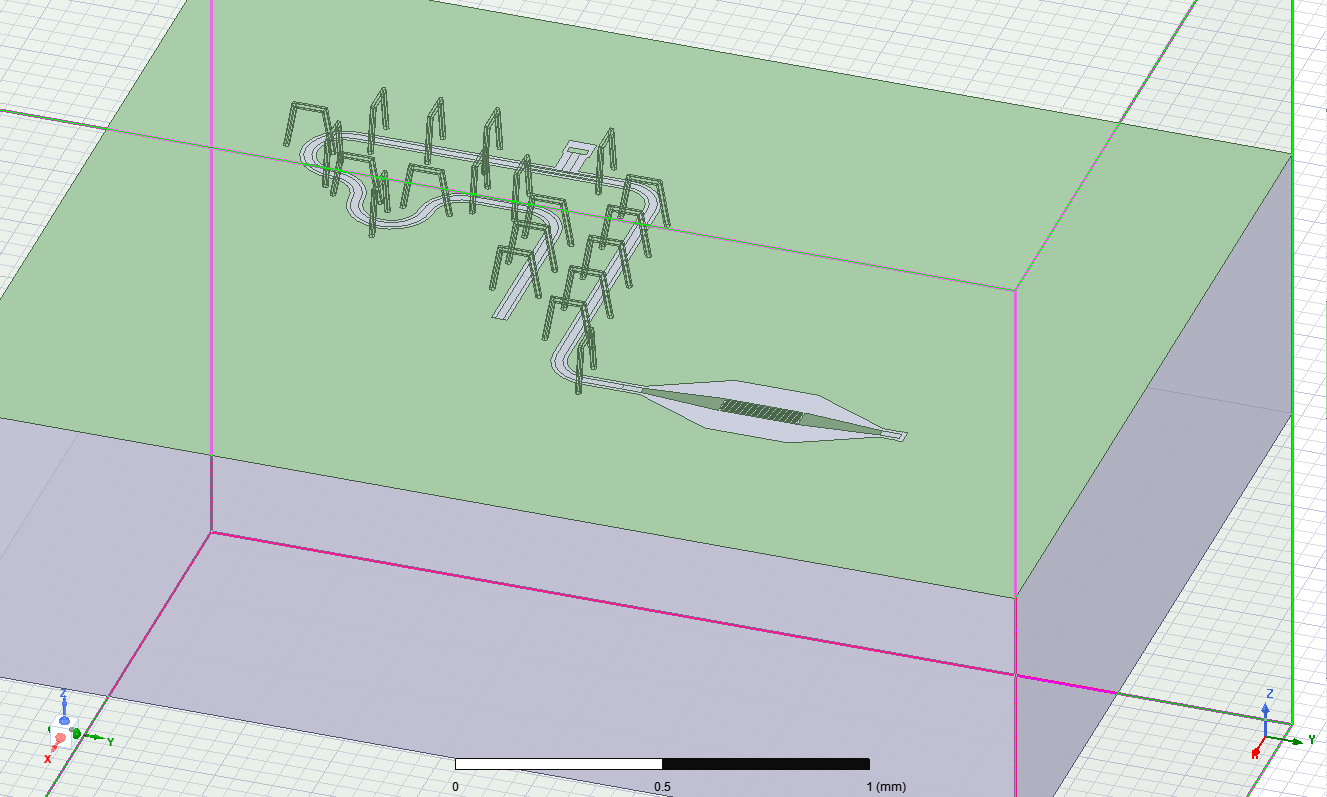

WindowsPath('c:/Users/Luxcuse/Documents/GitHub/qiskit-metal-SQNL/ansys.png')

In [118]:
Reset_v4.save_screenshot()

In [127]:
Reset_v4.add_sweep(setup_name="Setup",
               name="Sweep1",
               start_ghz=7,
               stop_ghz=7.5,
               count=501,
               type="Discrete"
               )

INFO 01:17PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [ ]:
Reset_v4.analyze_sweep('Sweep1', 'Setup')

In [126]:
data = Reset_v4.plot_params(['S11'])

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
data = data[0].to_numpy()

In [121]:
# data = np.transpose(data)
data

array([[0.93091816-0.36522784j],
       [0.93089536-0.3652849j ],
       [0.93087255-0.36534196j],
       ...,
       [0.75389054-0.6570002j ],
       [0.7538501 -0.65704652j],
       [0.75380966-0.65709284j]])

In [126]:
plt.plot(np.real(data))
plt.plot(np.imag(data))

In [125]:
plt.plot(np.real(data),np.imag(data))

In [75]:
em1.close()

# Calculators

In [51]:
Phi_0 = 2.067833848e-15
Delta_Al = 1.7e-4
Lj_test = 11.2
Ic_test = Phi_0/2/np.pi/Lj_test/1e-9
print("When Lj={:.3f}[nH],".format(Lj_test)+"Ic={:.3f}[nA]".format(Ic_test/1e-9))

When Lj=11.200[nH],Ic=29.384[nA]


In [52]:
print('Rn={}'.format(np.pi/2*Delta_Al/Ic_test))

Rn=9087.638640720297


In [ ]:
# Calculate RRR
R_300K = 11730
Ic = 23.2e-9

RRR = Ic * R_300K * 2 / np.pi / Delta_Al

print('RRR={}'.format(RRR))

RRR=1.019100931606024
